In [269]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Set working directory
import os
os.chdir("C:/Users/Simo/Documents/GitHub/Fission-Reactor-Physics")

In [ ]:
# Define energy classes from A4 to G
energy_classes = ["A4", "A3", "A2", "A1", "B", "C", "D", "E", "F", "G"]

# Number of buildings in the province today is 68967
Buildings = 68967

# Fossil fuel efficiency
efficiency = 0.85

# Heat pump efficiency
COP_cold = 4.5
COP_hot = 3.5

# As of 2025, only 9.58% of the buildings have cooling
cooling_share = 9.58/100 

# Heat Pump share class by class [%]
hp_dist = {
    "A4": 97.40,
    "A3": 91.48,
    "A2": 69.84,
    "A1": 53.05,
    "B": 36.63,
    "C": 32.23,
    "D": 21.32,
    "E": 12.19,
    "F": 6.66,
    "G": 1.77,
}

# Photovoltaic system share class by class [%]
pv_dist = {
    "A4": 96.71,
    "A3": 84.03,
    "A2": 59.73,
    "A1": 43.61,
    "B": 23.98,
    "C": 16.72,
    "D": 7.88,
    "E": 2.63,
    "F": 0.76,
    "G": 0.15,
}

avg_area = 90.99
# usage: reference power needed * correction factor = power needed corrected
correction_factors = {
    'A4': avg_area/687,
    'A3': avg_area/210,
    'A2': avg_area/164,
    'A1': avg_area/164,
    'B':  avg_area/306,
    'C':  avg_area/254,
    'D':  avg_area/347,
    'E':  avg_area/306,
    'F':  avg_area/155,
    'G':  avg_area/311
}

# inverted_correction_factors = {
#     "A4": 7.6923,
#     "A3": 2.3810,
#     "A2": 1.8519,
#     "A1": 1.8519,
#     "B": 3.4483,
#     "C": 2.8571,
#     "D": 3.8462,
#     "E": 3.4483,
#     "F": 1.7544,
#     "G": 3.4483,
# }

# correction_factors = {
#     'A4': 2.8,
#     'A3': 1.1,
#     'A2': 1.6,
#     'A1': 1.5,
#     'B': 1.2,
#     'C': 1.1,
#     'D': 1.2,
#     'E': 1.5,
#     'F': 2.2,
#     'G': 1.0,
# }


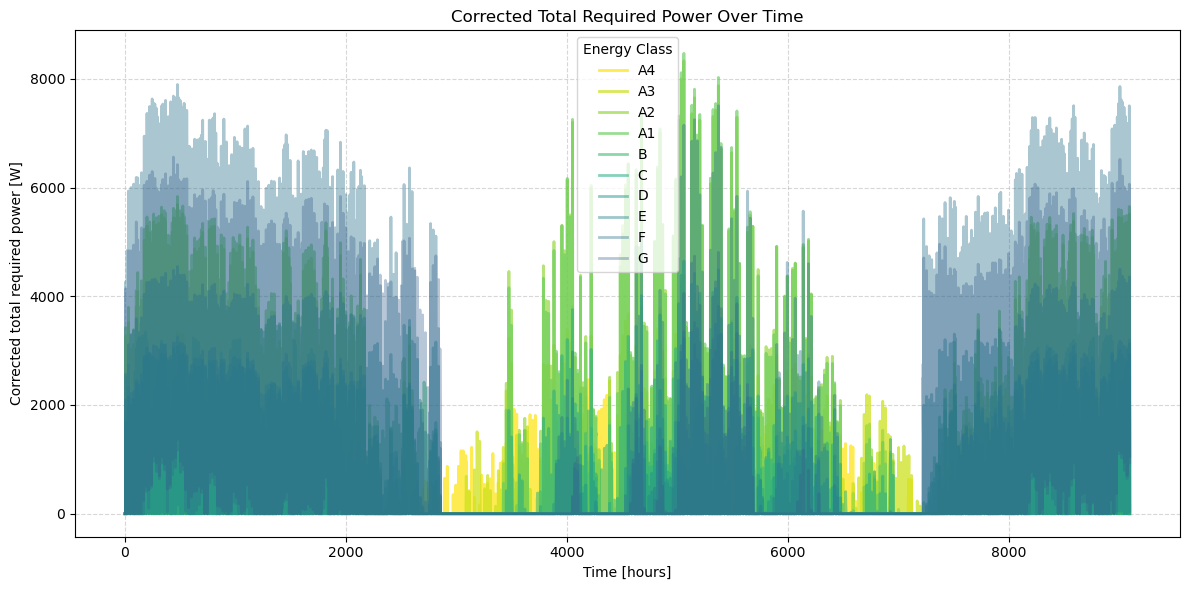

In [271]:
# Create colormap: fade from bold to faint
colors = cm.viridis(np.linspace(1, 0.3, len(energy_classes)))

# Store total_power data and track max for shared y-limit
tot_power = {}
hot_power = {}
cold_power = {}
max_power = 0

# First figure: overlaid curves
plt.figure(figsize=(12, 6))

for i, classe_energetica in enumerate(energy_classes):
    file_path = f".\\Integration of Nuclear and Renewables\\Project_Data\\Termolog_Calcolo_Dinamico_Orario\\{classe_energetica}.xlsx"
    df = pd.read_excel(file_path)

    # Clean column names
    clean_columns = {
        col: col.strip()
                .replace(" ", "_")
                .replace(",", "_")
                .replace("°", "")
                .replace("θ", "theta")
                .replace("Φ", "Phi")
                .replace("χ", "chi")
                .replace("ξ", "xi")
                .replace(".", "_")
                .replace("/", "_")
        for col in df.columns
    }
    df.rename(columns=clean_columns, inplace=True)

    # Compute and apply correction factor
    correction = correction_factors[classe_energetica]
    #+ df["Phi_hum_nd"] + df["Phi_dehum_nd"]
    thermal_power = df["Phi_HC_nd"] * correction
    hot_power_temp = thermal_power.copy()
    cold_power_temp = thermal_power.copy()
    hot_power_temp[hot_power_temp < 0] = 0
    cold_power_temp[cold_power_temp > 0] = 0
    cold_power_temp = abs(cold_power_temp)
    
    total_power = hot_power_temp + cold_power_temp
    hot_power[classe_energetica] = hot_power_temp
    cold_power[classe_energetica] = cold_power_temp
    tot_power[classe_energetica] = total_power
    max_power = max(max_power, total_power.max())

    # Plot in overlaid figure
    plt.plot(total_power, label=classe_energetica, color=colors[i], alpha=0.8 - i * 0.05, linewidth=2)

plt.legend(title="Energy Class")
plt.xlabel("Time [hours]")
plt.ylabel("Corrected total required power [W]")
plt.title("Corrected Total Required Power Over Time")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(".\\Integration of Nuclear and Renewables\\Project_Data\\Plots\\Overall.png")
plt.show()

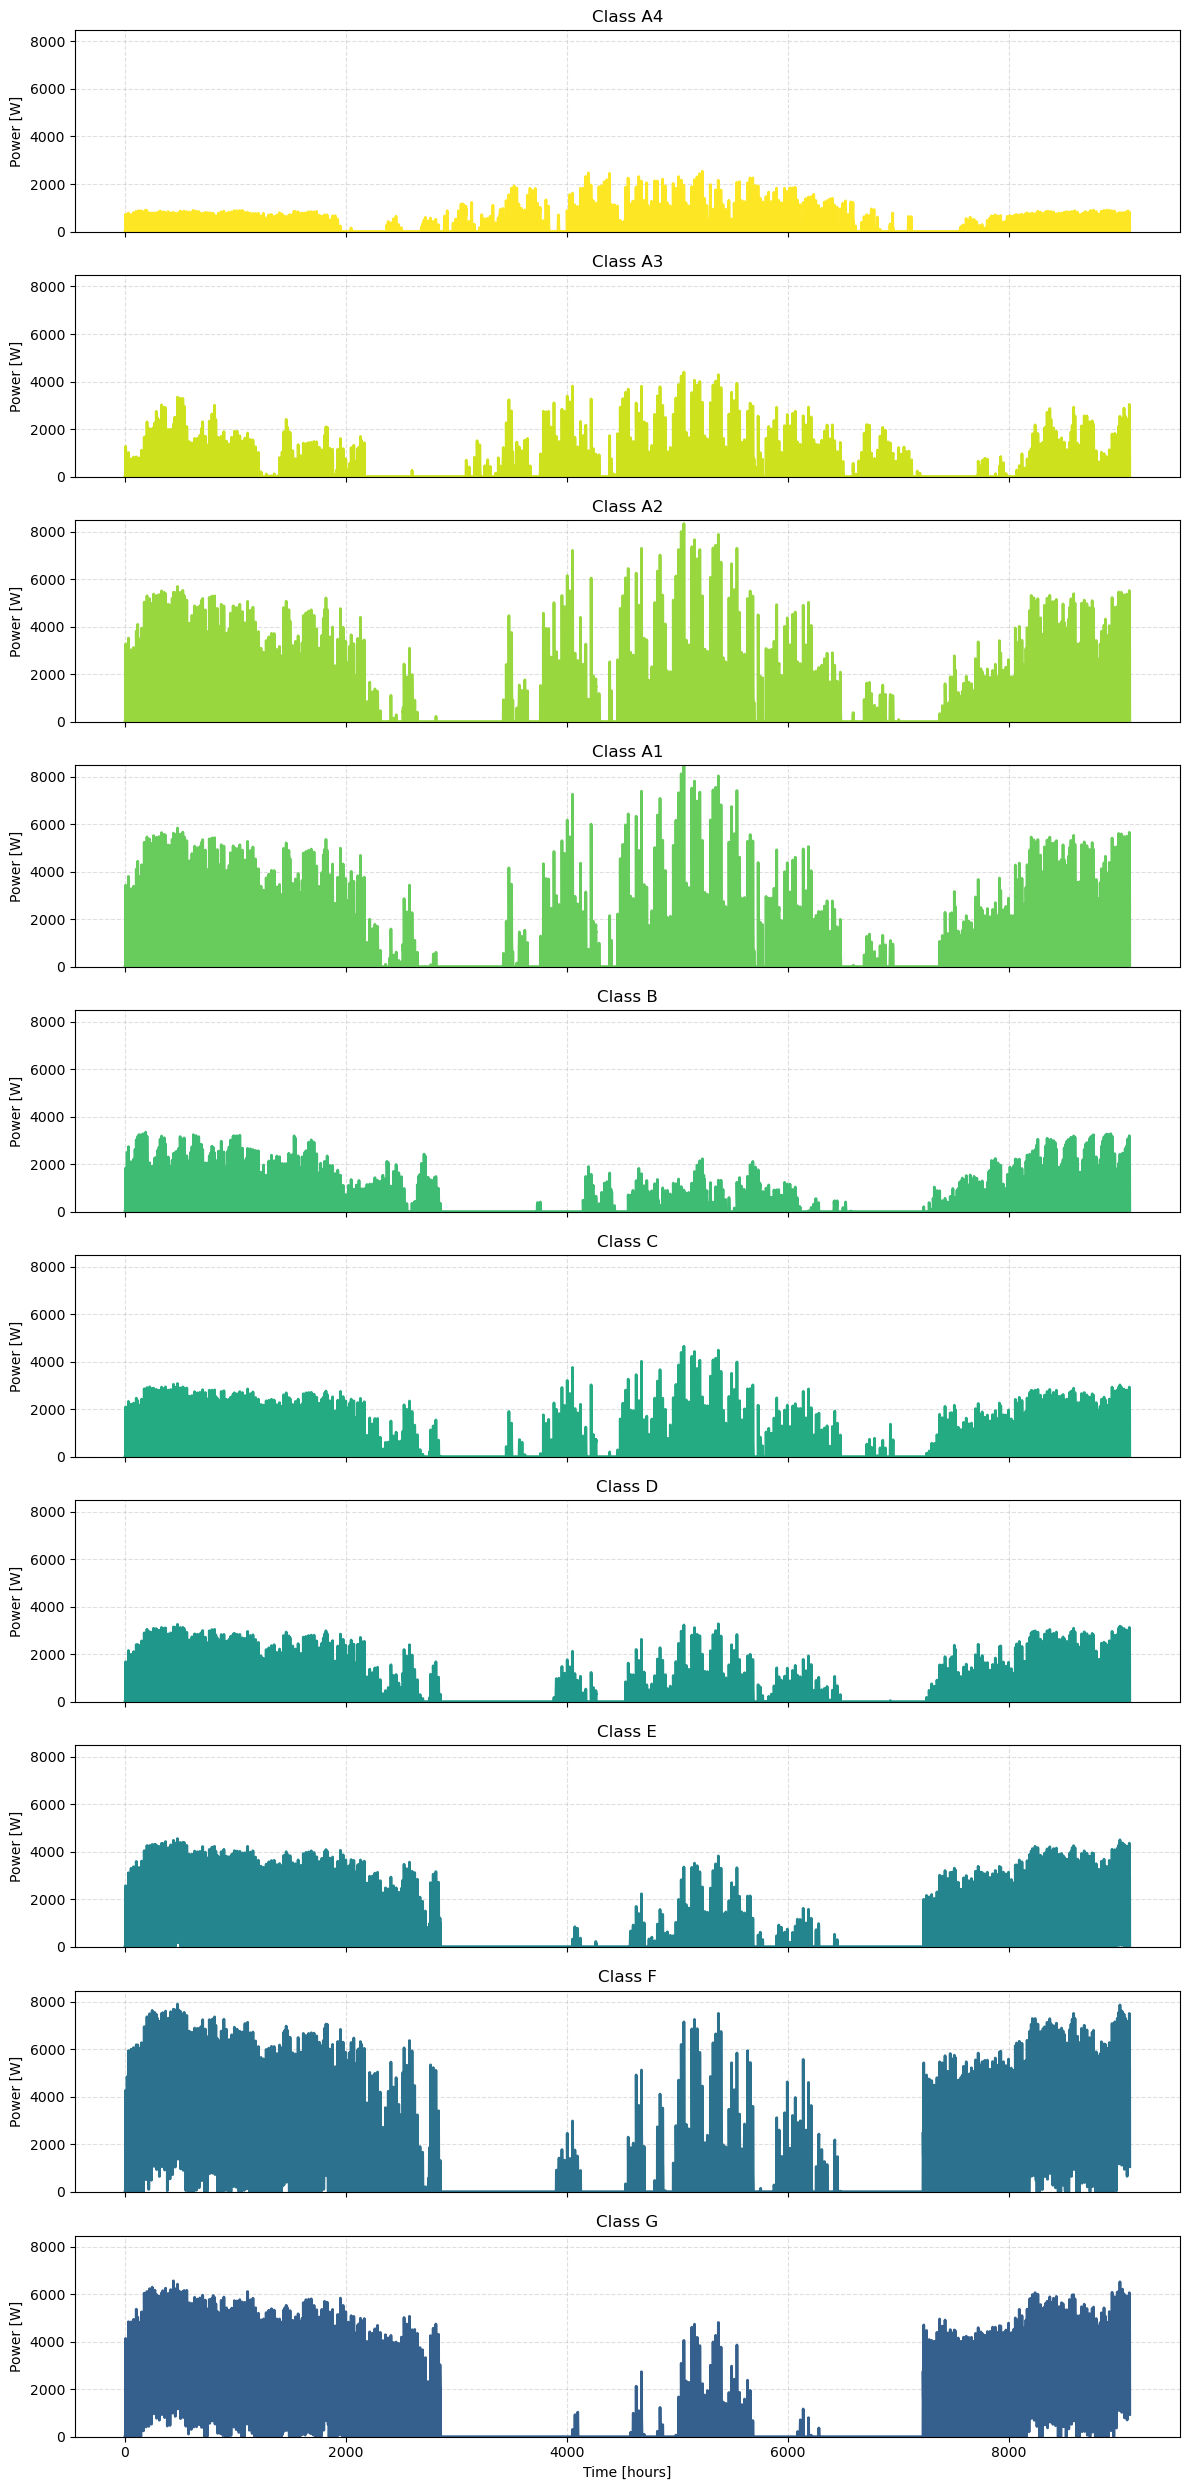

In [272]:
# Second figure: subplots for each class with shared y-axis limit
fig, axes = plt.subplots(len(energy_classes), 1, figsize=(12, 2.5 * len(energy_classes)), sharex=True)

for i, classe in enumerate(energy_classes):
    ax = axes[i]
    ax.plot(tot_power[classe], color=colors[i], linewidth=2)
    ax.set_ylim(0, max_power)
    ax.set_ylabel("Power [W]")
    ax.set_title(f"Class {classe}")
    ax.grid(True, linestyle='--', alpha=0.4)

axes[-1].set_xlabel("Time [hours]")
plt.tight_layout()
plt.savefig(".\\Integration of Nuclear and Renewables\\Project_Data\\Plots\\Subplots_Comparison.png")
plt.show()


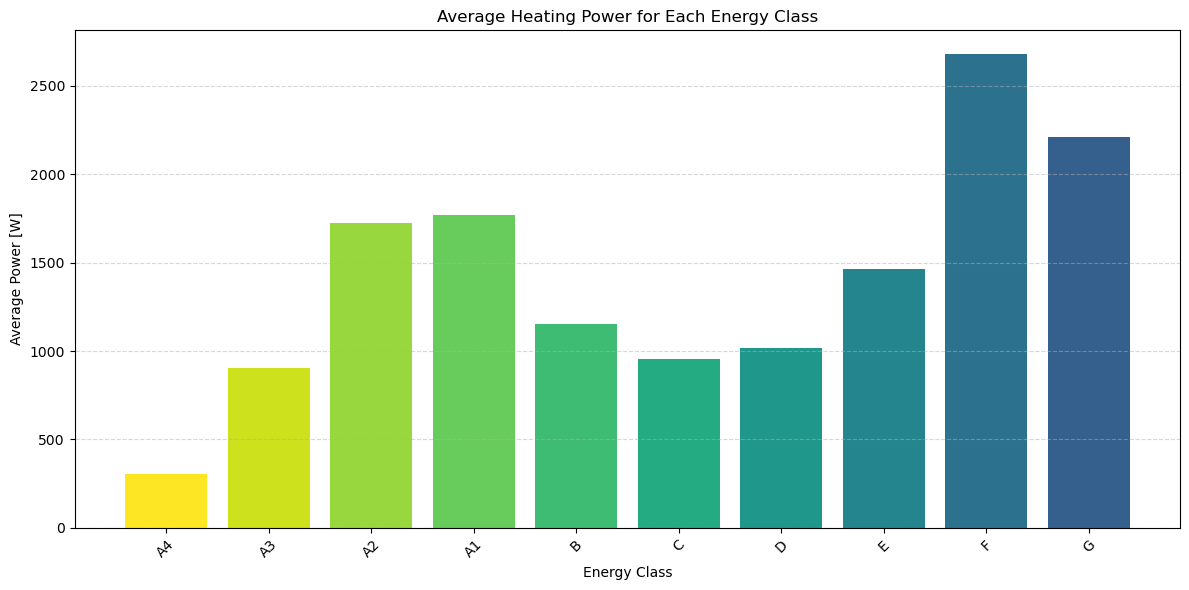

In [273]:
# Add a plot with the average power for each class
plt.figure(figsize=(12, 6))
average_powers = [power[power != 0].mean() for power in hot_power.values()]
plt.bar(energy_classes, average_powers, color=colors)
plt.xlabel("Energy Class")
plt.ylabel("Average Power [W]")
plt.title("Average Heating Power for Each Energy Class")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
# plt.savefig(".\\Integration of Nuclear and Renewables\\Project_Data\\Plots\\Average_Power.png")

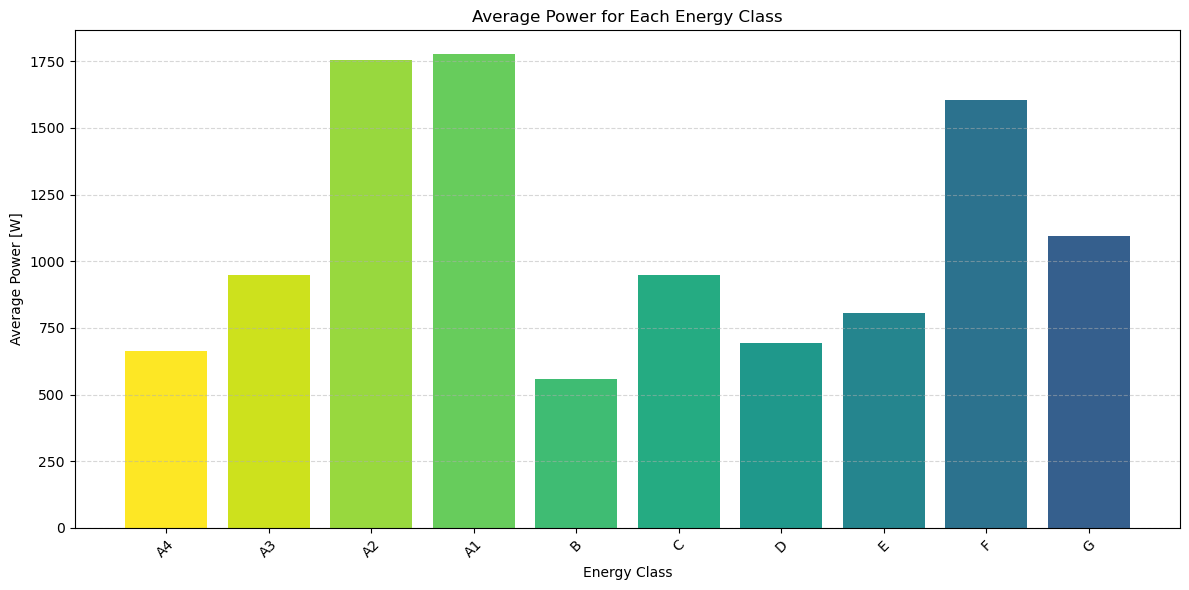

In [274]:
# Add a plot with the average power for each class
plt.figure(figsize=(12, 6))
average_powers = [power[power != 0].mean() for power in cold_power.values()]
plt.bar(energy_classes, average_powers, color=colors)
plt.xlabel("Energy Class")
plt.ylabel("Average Power [W]")
plt.title("Average Power for Each Energy Class")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
# plt.savefig(".\\Integration of Nuclear and Renewables\\Project_Data\\Plots\\Average_Power.png")

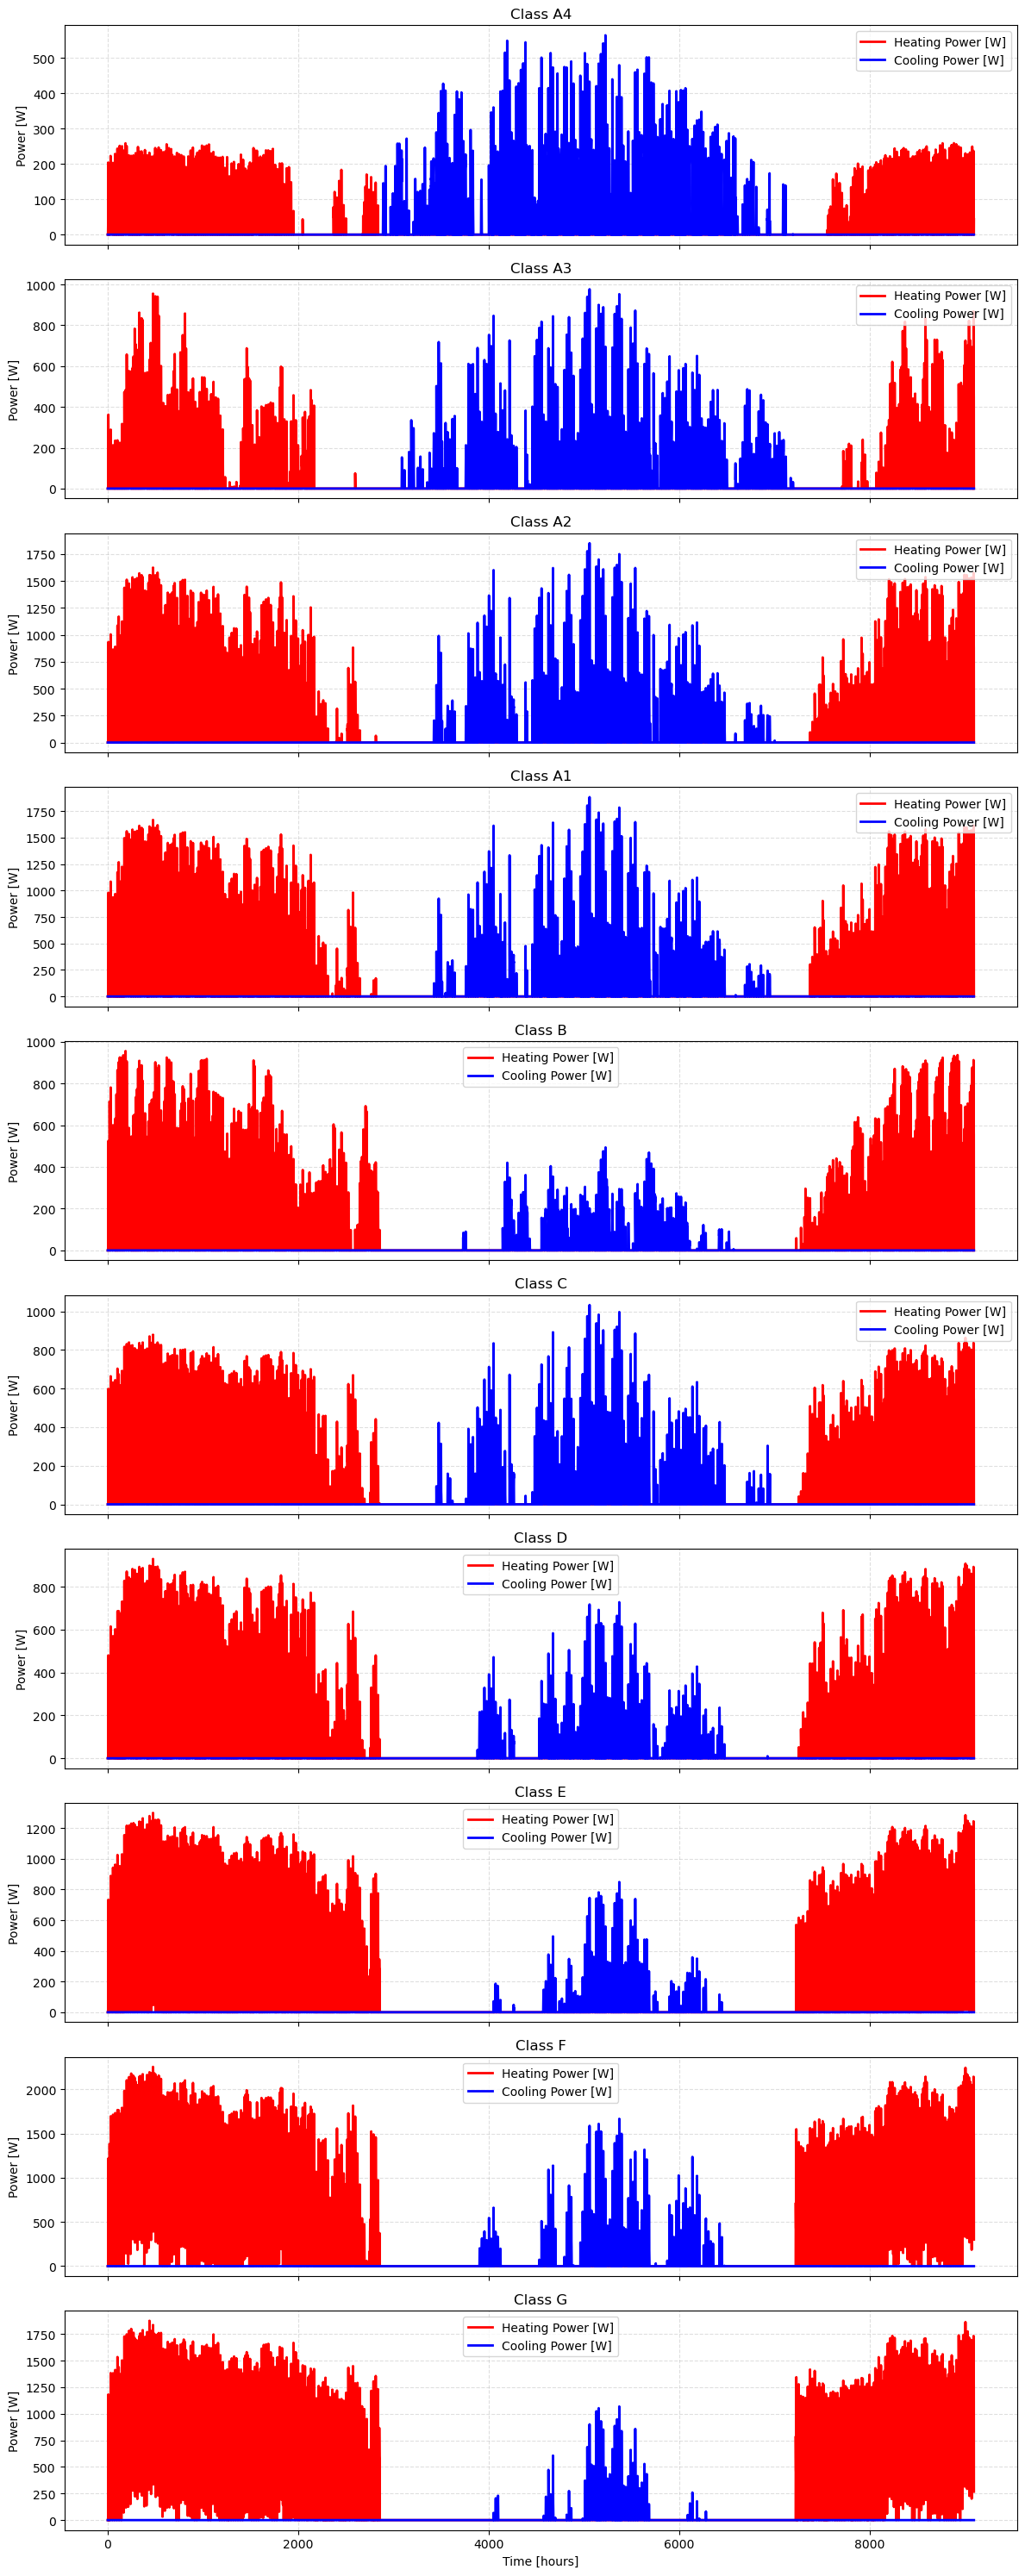

In [275]:
import matplotlib.pyplot as plt
import pandas as pd

fig, axes = plt.subplots(len(energy_classes), 1, figsize=(12, 3 * len(energy_classes)), sharex=True)
electric_power = {}
for i, classe_energetica in enumerate(energy_classes):
    # Convert to electrical power
    COP_hot = 3.5
    COP_cold = 4.5
    hot_power_e = hot_power[classe_energetica] / COP_hot
    cold_power_e = cold_power[classe_energetica] / COP_cold
    electric_power[classe_energetica] = hot_power_e + cold_power_e
    # Create a DataFrame for the electric power

    # Plot both on the same subplot
    ax = axes[i]
    ax.plot(hot_power_e.values, label='Heating Power [W]', color='red', linewidth=2)
    ax.plot(cold_power_e.values, label='Cooling Power [W]', color='blue', linewidth=2)
    ax.set_ylabel("Power [W]")
    ax.set_title(f"Class {classe_energetica}")
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend()

axes[-1].set_xlabel("Time [hours]")
plt.tight_layout()
plt.show()


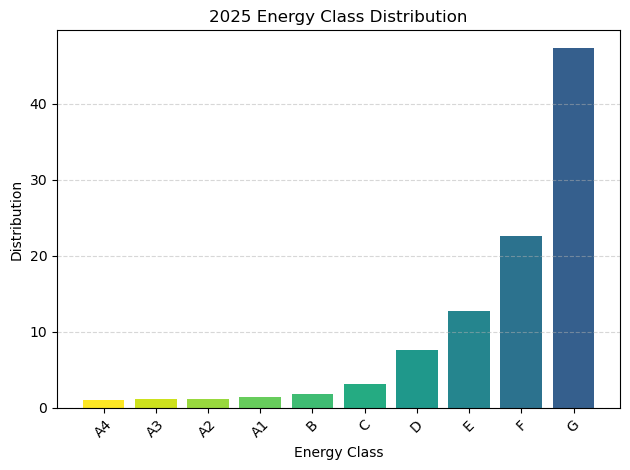

In [276]:
# Create a distribution of energy classes
energy_class_distribution_today = {
"A4": 1.03,
"A3": 1.14,
"A2": 1.14,
"A1": 1.48,
"B": 1.83,
"C": 3.08,
"D": 7.65,
"E": 12.79,
"F": 22.60,
"G": 47.26,
}
# Plot the distribution
# plt.figure(figsize=(12, 6))
plt.bar(energy_class_distribution_today.keys(), energy_class_distribution_today.values(), color=colors)
plt.xlabel("Energy Class")
plt.ylabel("Distribution")
plt.title("2025 Energy Class Distribution")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

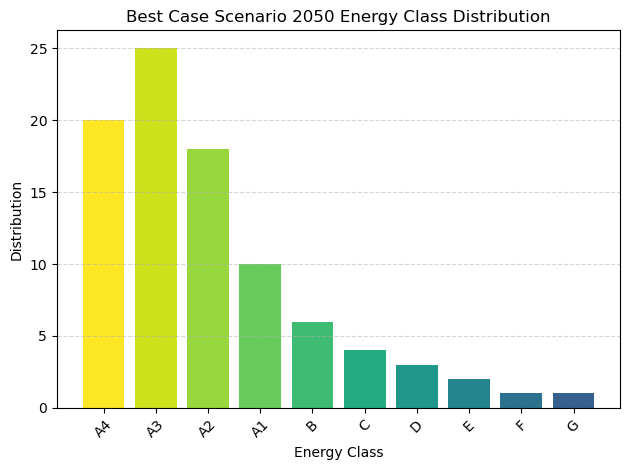

In [277]:
# Create a distribution of energy classes
energy_class_distribution_best = {
    "A4": 20.0,
    "A3": 25.0,
    "A2": 18.0,
    "A1": 10.0,
    "B": 6.0,
    "C": 4.0,
    "D": 3.0,
    "E": 2.0,
    "F": 1.0,
    "G": 1.0,
}
# Plot the distribution
# plt.figure(figsize=(12, 6))
plt.bar(energy_class_distribution_best.keys(), energy_class_distribution_best.values(), color=colors)
plt.xlabel("Energy Class")
plt.ylabel("Distribution")
plt.title("Best Case Scenario 2050 Energy Class Distribution")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

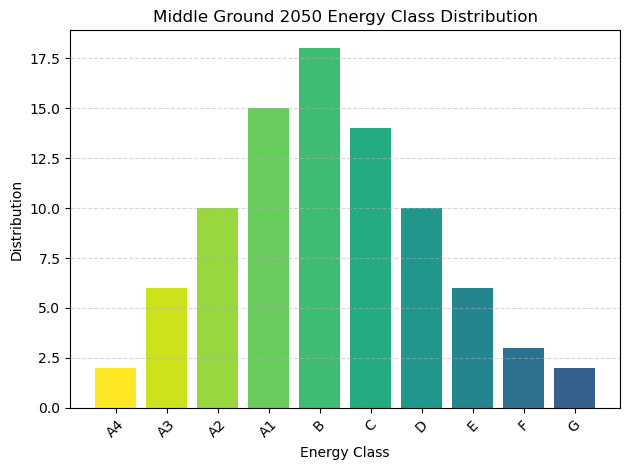

In [278]:
energy_class_distribution_mid = {
    "A4": 2.0,
    "A3": 6.0,
    "A2": 10.0,
    "A1": 15.0,
    "B": 18.0,
    "C": 14.0,
    "D": 10.0,
    "E": 6.0,
    "F": 3.0,
    "G": 2.0,
}
# Plot the distribution
# plt.figure(figsize=(12, 6))
plt.bar(energy_class_distribution_mid.keys(), energy_class_distribution_mid.values(), color=colors)
plt.xlabel("Energy Class")
plt.ylabel("Distribution")
plt.title("Middle Ground 2050 Energy Class Distribution")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

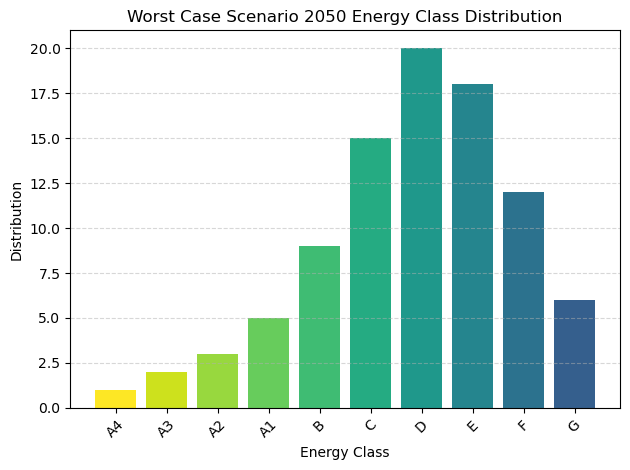

In [279]:
energy_class_distribution_worst = {
    "A4": 1.0,
    "A3": 2.0,
    "A2": 3.0,
    "A1": 5.0,
    "B": 9.0,
    "C": 15.0,
    "D": 20.0,
    "E": 18.0,
    "F": 12.0,
    "G": 6.0,
}
# Plot the distribution
# plt.figure(figsize=(12, 6))
plt.bar(energy_class_distribution_worst.keys(), energy_class_distribution_worst.values(), color=colors)
plt.xlabel("Energy Class")
plt.ylabel("Distribution")
plt.title("Worst Case Scenario 2050 Energy Class Distribution")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

In [384]:
# From this point on we have to choose a distribution to work with, let's say the best one for now
energy_class_distribution = energy_class_distribution_today

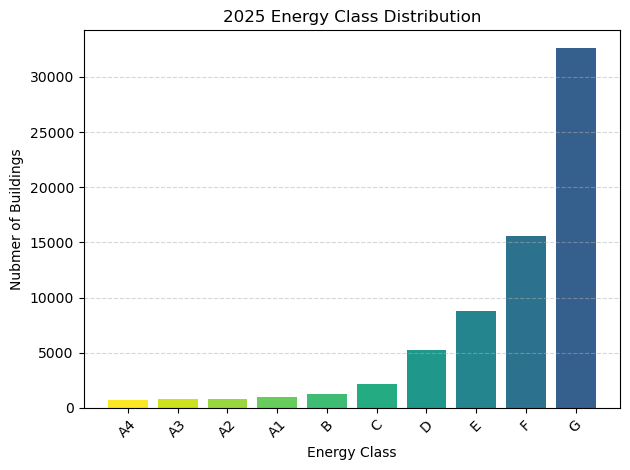

In [385]:
# Scale the distribution to the number of buildings
buildings_per_class = {k: v * Buildings / 100 for k, v in energy_class_distribution.items()}
# Plot the distribution
# plt.figure(figsize=(12, 6))
plt.bar(buildings_per_class.keys(), buildings_per_class.values(), color=colors)
plt.xlabel("Energy Class")
plt.ylabel("Nubmer of Buildings")
plt.title("2025 Energy Class Distribution")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

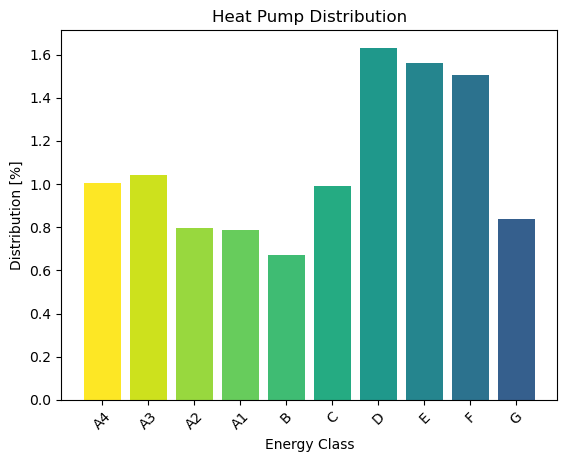

In [386]:
# Distribution of buildings with heat pumps, class by class, in the province
Heat_Pump_Distribution = {}

# Set the distribution of energy classes
for energy_class, share in energy_class_distribution.items():
    Heat_Pump_Distribution[energy_class] = hp_dist[energy_class]/100 * share
    
# Plot the distribution
# plt.figure(figsize=(12, 6))
plt.bar(Heat_Pump_Distribution.keys(), Heat_Pump_Distribution.values(), color=colors)
plt.xlabel("Energy Class")
plt.ylabel("Distribution [%]")
plt.title("Heat Pump Distribution")
plt.xticks(rotation=45)
plt.show()
    

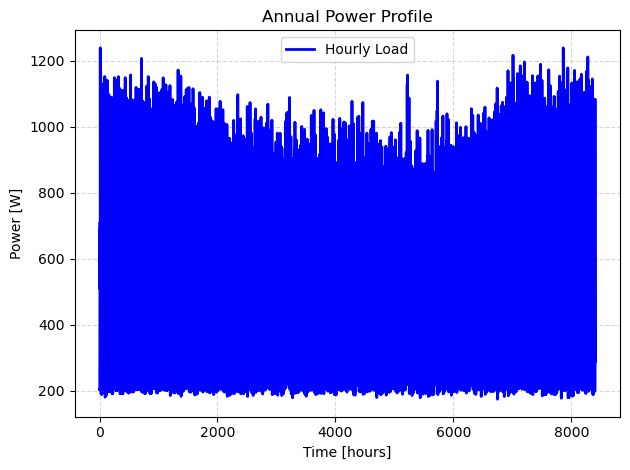

In [387]:
# Assume is the same for all classes
standby = 200
induction_share = 0.35  # percentuale di case con piano a induzione (es. 35%)
induction_profile = np.zeros(24)
induction_profile[7] = 800
induction_profile[12] = 1200
induction_profile[13] = 600
induction_profile[18] = 800
induction_profile[19] = 1000

# Potenza in Watt ora per ora (senza carico di fondo)
winter_weekday_appliances = [
    0, 0, 0, 0, 20, 90,  440, 240, 40,  20,  0,   0,  0,   0,   0,   0,   20,  40,  340, 540, 440, 240, 90,  20]
winter_weekend_appliances = [
    0, 0, 0, 0, 20, 100, 500, 300, 200, 250, 100, 80, 300, 400, 200, 150, 100, 150, 350, 550, 450, 300, 120, 50]

fan_load = 100
summer_weekday_appliances = [
    0, 0, 0, 0, 10, 60, 200, 120, 30, 20 + fan_load, fan_load, fan_load, fan_load, fan_load, fan_load, fan_load, fan_load, fan_load + 30, 200 + fan_load, 300 + fan_load, 200 + fan_load, 60 + fan_load, fan_load]
summer_holiday_appliances = [
    0, 0, 0, 0, 20, 80, 250, 150, 100, 120 + fan_load, fan_load, fan_load, 200 + fan_load, 250 + fan_load, fan_load, fan_load, 100 + fan_load, 150 + fan_load, 250 + fan_load, 350 + fan_load, 220 + fan_load, 80 + fan_load, fan_load]

winter_special_profile = [
    0, 0, 0, 0, 30, 100, 300, 200, 300, 500, 400, 350, 600, 700, 400, 300, 200, 300, 500, 600, 400, 300, 150, 80]

summer_special_summer = [
    0, 0, 0, 0, 20, 60, 200, 150, 250 + fan_load, 300 + fan_load, 250 + fan_load, 200 + fan_load, 300 + fan_load, 350 + fan_load, 250 + fan_load, 200 + fan_load, 180 + fan_load, 220 + fan_load, 300 + fan_load, 400 + fan_load, 300 + fan_load, 200 + fan_load, 100 + fan_load, 50]

vacation_factor = 0.86

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np

# Date delle festività nel 2025
holidays = {
    '2025-01-01': 'Capodanno',
    '2025-01-06': 'Epifania',
    '2025-04-20': 'Pasqua',
    '2025-04-21': 'Lunedì dell\'Angelo',
    '2025-04-25': 'Festa della Liberazione',
    '2025-05-01': 'Festa dei Lavoratori',
    '2025-06-02': 'Festa della Repubblica',
    '2025-08-15': 'Ferragosto',
    '2025-11-01': 'Ognissanti',
    '2025-12-08': 'Immacolata Concezione',
    '2025-12-25': 'Natale',
    '2025-12-26': 'Santo Stefano'
}

# Settimane di ferie estive
vacation_weeks = [
    ('2025-07-28', '2025-08-03'),
    ('2025-08-04', '2025-08-10'),
    ('2025-08-11', '2025-08-17'),
    ('2025-08-18', '2025-08-24'),
    ('2025-08-25', '2025-08-31'),
    ('2025-09-01', '2025-09-07')
]

# Funzione per determinare se una data è durante le ferie estive
def is_vacation(date):
    for start, end in vacation_weeks:
        if start <= date.strftime('%Y-%m-%d') <= end:
            return True
    return False

# Funzione S-shaped (sigmoide) per la transizione vacanza
def vacation_blend_factor(date):
    for start, end in vacation_weeks:
        start_date = datetime.strptime(start, "%Y-%m-%d")
        end_date = datetime.strptime(end, "%Y-%m-%d")
        total_days = (end_date - start_date).days + 1
        if start_date <= date <= end_date:
            x = (date - start_date).days / total_days
            return 1 - 1 / (1 + np.exp(-10 * (x - 0.5)))
    return 0

# Funzione per transizione stagionale
def seasonal_blend_factor(date):
    day_of_year = date.timetuple().tm_yday
    if 60 <= day_of_year <= 120:
        return (day_of_year - 60) / (120 - 60)
    elif 120 < day_of_year < 273:
        return 1.0
    elif 273 <= day_of_year <= 304:
        return 1.0 - (day_of_year - 273) / (304 - 273)
    else:
        return 0.0

# Profilo annuale
other_electric_needs = []
start_date = datetime(2025, 1, 1)
end_date = datetime(2025, 12, 31)
current_date = start_date

rng = np.random.default_rng(seed=42)  # riproducibilità

while current_date <= end_date:
    date_str = current_date.strftime('%Y-%m-%d')
    weekday = current_date.weekday()
    is_holiday = date_str in holidays
    season_blend = seasonal_blend_factor(current_date)
    vac_blend = vacation_blend_factor(current_date)

    if is_holiday:
        daily_profile = summer_special_summer if season_blend > 0.5 else winter_special_profile
    else:
        if weekday < 5:
            winter_day = winter_weekday_appliances
            summer_day = summer_weekday_appliances
        else:
            winter_day = winter_weekend_appliances
            summer_day = summer_holiday_appliances

        daily_profile = [
            (1 - season_blend) * w + season_blend * s
            for w, s in zip(winter_day, summer_day)
        ]

    if vac_blend > 0:
        daily_profile = [(1 - vac_blend * (1 - vacation_factor)) * val for val in daily_profile]

    # Aggiungi variazione giornaliera casuale per rappresentare giornate buone o cattive (es. meteo)
    weather_factor = rng.normal(loc=1.0, scale=0.05)  # variazione ±5% circa

    daily_profile = [weather_factor * (val + standby + (induction_share * induction_profile[i])) for i, val in enumerate(daily_profile)]
    other_electric_needs.extend(daily_profile)
    current_date += timedelta(days=1)

# Convert to DataFrame and resample to hourly data
other_electric_needs = pd.Series(other_electric_needs)

# Plot finale con curva media
plt.plot(other_electric_needs, color='blue', linewidth=2, label="Hourly Load")
plt.xlabel("Time [hours]")
plt.ylabel("Power [W]")
plt.title("Annual Power Profile")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
# n=1
# plt.xlim(0+24*n,24+24*n)
plt.show()


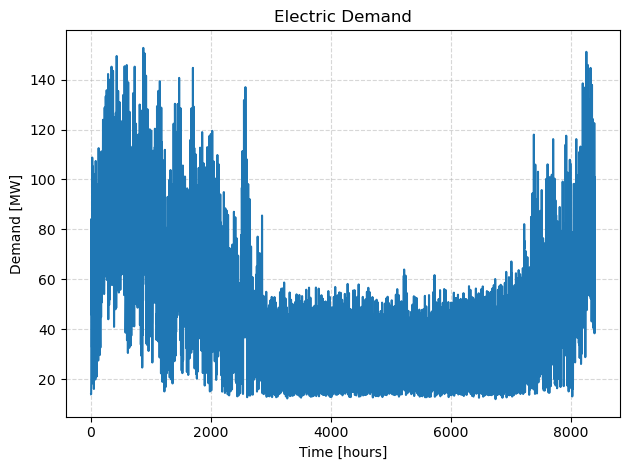

In [392]:
# Determine teh damnds of fossil and electric power
fossil_fuel_demand = {}
electric_demand = {}

total_electric_demand = 0
total_fossil_fuel_demand = 0

for energy_class, share in energy_class_distribution.items():
    fossil_fuel_demand[energy_class] = hot_power[energy_class] / efficiency
    electric_demand[energy_class] = hot_power[energy_class] / COP_hot + cooling_share * cold_power[energy_class] / COP_cold
    # Scale by the number of buildings * the share of the class
    fossil_fuel_demand[energy_class] *= buildings_per_class[energy_class] * (1-Heat_Pump_Distribution[energy_class]/100)
    electric_demand[energy_class] *= buildings_per_class[energy_class] * (Heat_Pump_Distribution[energy_class])
    electric_demand[energy_class] +=  other_electric_needs * buildings_per_class[energy_class]
    # Add to the total
    total_electric_demand += electric_demand[energy_class]
    total_fossil_fuel_demand += fossil_fuel_demand[energy_class]   
    
# Smooth the hourly profiles by +-1 hour with moving average
smooth_electric_demand = pd.Series(total_electric_demand).rolling(window=3, center=True).mean()
smooth_fossil_fuel_demand = pd.Series(total_fossil_fuel_demand).rolling(window=3, center=True).mean()

# Plot the smoothed total demand of electricity and fossil fuels
# plt.figure(figsize=(12, 6))
plt.plot(smooth_electric_demand/1e6, label="Electric Demand")
plt.xlabel("Time [hours]")
plt.ylabel("Demand [MW]")
plt.title("Electric Demand")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

In [389]:
# Average electric demand
total_yearly_electric_demand = total_electric_demand.sum()
display(f"Total Yearly Electric Demand {(total_yearly_electric_demand / 1e9):.2f} GWh")
total_by_household = total_yearly_electric_demand / Buildings
display(f"Total Yearly Electric Demand per Household {(total_by_household / 1e3):.2f} kWh")
CENED_data = 61182892.4
display(f"Ratio: this estimate / CENED data: {(total_yearly_electric_demand/1000 / CENED_data)*100:.0f}%")

'Total Yearly Electric Demand 372.93 GWh'

'Total Yearly Electric Demand per Household 5407.34 kWh'

'Ratio: this estimate / CENED data: 610%'

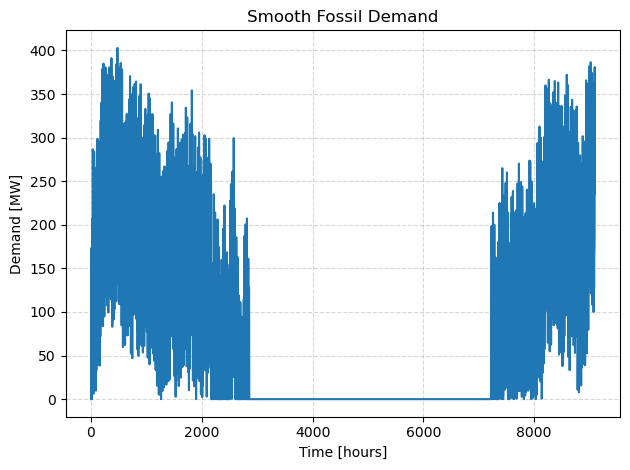

In [390]:
plt.plot(smooth_fossil_fuel_demand/1e6, label="Fossil Demand")
plt.xlabel("Time [hours]")
plt.ylabel("Demand [MW]")
plt.title("Smooth Fossil Demand")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

In [391]:
photovoltaic_share = {
    "A4": 96.71,
    "A3": 84.03,
    "A2": 59.73,
    "A1": 43.61,
    "B": 23.98,
    "C": 16.72,
    "D": 7.88,
    "E": 2.63,
    "F": 0.76,
    "G": 0.15
}

selfsufficency_coeff = {
    "A4": 61.51,
    "A3": 44.08,
    "A2": 31.68,
    "A1": 25.57,
    "B": 19.29,
    "C": 15.51,
    "D": 9.16,
    "E": 3.92,
    "F": 1.15,
    "G": 0.24
}

overdimensioning_coeff = {
    "A4": 3.96,
    "A3": 34.20,
    "A2": 267.82,
    "A1": 1004.33,
    "B": 947.18,
    "C": 419.08,
    "D": 102.67,
    "E": 116.66,
    "F": -68.68,
    "G": -95.72
}